In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


**PARAMETERS**

In [2]:
MAX_EPOCHS = 20
CONV_WIDTH = 3 

In [44]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [45]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# WINDOW GENERATOR

In [46]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                            sequence_stride=1,
                                                            shuffle=True,
                                                            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3, figsize=(12, 8)):
        inputs, labels = self.example
        plt.figure(figsize=figsize)
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                   label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                      edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

# COMPILE

In [47]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [48]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

In [49]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),

])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

2629/2629 [==============================] - 5s 2ms/step - loss: 4.7560 - mean_absolute_error: 0.0501


In [51]:
conv_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 32)             1376      
                                                                 
 dense_7 (Dense)             (None, 1, 32)             1056      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [52]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [53]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


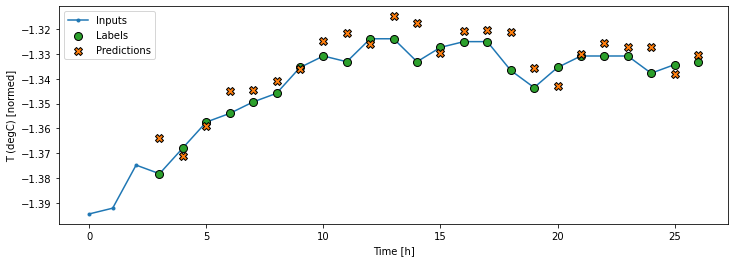

In [54]:
wide_conv_window.plot(conv_model,max_subplots=1,figsize=(12,4))

In [55]:
val_performance

{'Conv': [4.755964756011963, 0.050082165747880936]}

In [56]:
performance

{'Conv': [0.0007041989592835307, 0.01803181879222393]}

In [66]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24, 32)            6016      
                                                                 
 dense_9 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [57]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])


lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True), #normalemenet 32
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2628/2628 [==============================] - 6s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0154


In [78]:
def build_model():
    # Define model layers.
    input_layer = tf.keras.layers.Input(shape=(24, 14))
    
    first_lstm = tf.keras.layers.LSTM(32, return_sequences=True)(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = tf.keras.layers.Dense(units='1', name='VPact')(first_lstm)
    
    second_lstm = tf.keras.layers.LSTM(32, return_sequences=True)(first_lstm)
    # Y2 output will be fed from the second dense
    y2_output = tf.keras.layers.Dense(units='1',name='Tdegc')(second_lstm)    # Define the model with the input layer 
    # and a list of output layers
    model = tf.keras.Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model

In [83]:
lstm_model.__dict__

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, 24, 14]),
 '_saved_model_inputs_spec': TensorSpec(shape=(32, 24, 14), dtype=tf.float32, name='lstm_5_input'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(32, 24, 14), dtype=tf.float32, name='lstm_5_input')],
  {}),
 '_supports_masking': True,
 '_name': 'sequential_7',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7f4cefcb79c0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f4cefbc1c40>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackables': [<

In [81]:
lstm_model2.__dict__

{'_self_setattr_tracking': True,
 '_is_model_for_instrumentation': True,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_input_spec': None,
 '_build_input_shape': TensorShape([None, 24, 14]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 24, 14), dtype=tf.float32, name='input_6'),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, 24, 14), dtype=tf.float32, name='input_6')],
  {}),
 '_supports_masking': True,
 '_name': 'model_2',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7f4ba828f8d0>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f4ceda8e140>,
 '_dtype_policy': <Policy "float32">,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_self_tracked_trackables': [<keras.engin

In [84]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])


lstm_model2 = build_model()

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model2(wide_window.example[0])[0].shape)

history = compile_and_fit(lstm_model2, wide_window)

IPython.display.clear_output()
val_performance['LSTM2'] = lstm_model2.evaluate(wide_window.val)
performance['LSTM2'] = lstm_model2.evaluate(wide_window.test, verbose=0)

2628/2628 [==============================] - 8s 3ms/step - loss: 0.0016 - VPact_loss: 8.2289e-04 - Tdegc_loss: 7.8719e-04 - VPact_mean_absolute_error: 0.0147 - Tdegc_mean_absolute_error: 0.0146


In [87]:
lstm_model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 24, 14)]     0           []                               
                                                                                                  
 lstm_17 (LSTM)                 (None, 24, 32)       6016        ['input_7[0][0]']                
                                                                                                  
 lstm_18 (LSTM)                 (None, 24, 32)       8320        ['lstm_17[0][0]']                
                                                                                                  
 VPact (Dense)                  (None, 24, 1)        33          ['lstm_17[0][0]']                
                                                                                            

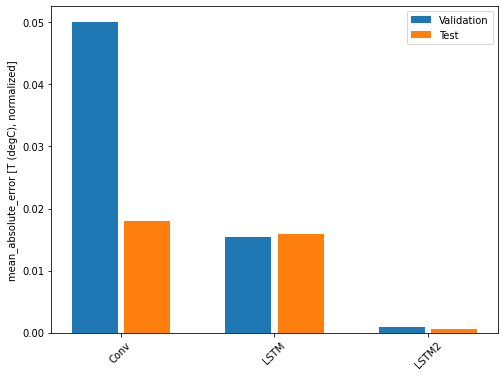

In [85]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [91]:
inputs, labels = wide_window.example

In [94]:
lstm_model2(inputs)

[<tf.Tensor: shape=(32, 24, 1), dtype=float32, numpy=
 array([[[ 1.34586906e+00],
         [ 1.33989203e+00],
         [ 1.38870990e+00],
         [ 1.37669587e+00],
         [ 1.36557674e+00],
         [ 1.36339140e+00],
         [ 1.36555827e+00],
         [ 1.34592938e+00],
         [ 1.34399521e+00],
         [ 1.31387472e+00],
         [ 1.32997954e+00],
         [ 1.30739892e+00],
         [ 1.33478105e+00],
         [ 1.32029808e+00],
         [ 1.31840515e+00],
         [ 1.32250559e+00],
         [ 1.30669475e+00],
         [ 1.28181255e+00],
         [ 1.27512658e+00],
         [ 1.26054204e+00],
         [ 1.22171426e+00],
         [ 1.23343110e+00],
         [ 1.22288740e+00],
         [ 1.23632801e+00]],
 
        [[ 1.83859372e+00],
         [ 1.75602579e+00],
         [ 1.63410461e+00],
         [ 1.57101595e+00],
         [ 1.51537859e+00],
         [ 1.46545196e+00],
         [ 1.37771118e+00],
         [ 1.34682131e+00],
         [ 1.30979562e+00],
         [ 1.275017

In [100]:
def wplot(model=lstm_model2, plot_col='T (degC)', max_subplots=3, figsize=(12, 8)):
    inputs, labels = wide_window.example
    plt.figure(figsize=figsize)
    plot_col_index = wide_window.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(wide_window.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)

        if wide_window.label_columns:
            label_col_index = wide_window.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(wide_window.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)[1]
            plt.scatter(wide_window.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

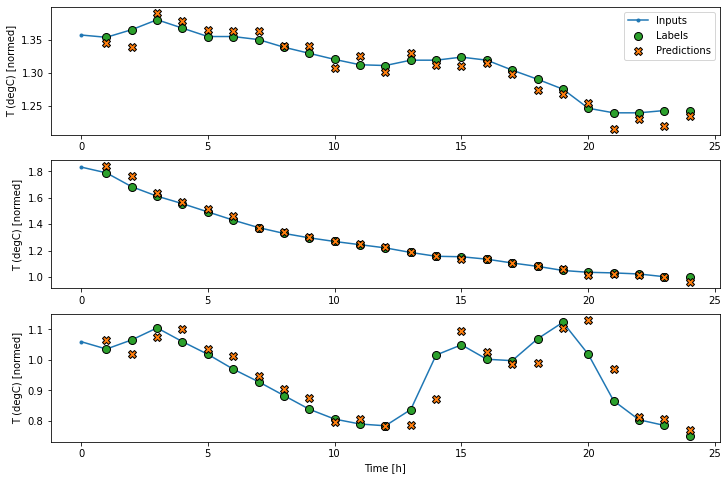

In [101]:
wplot()

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")